In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import directed_hausdorff

# Create a straw template

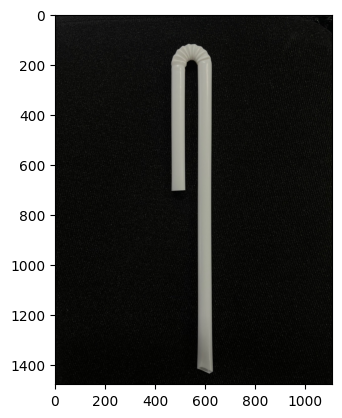

In [2]:
# Load the image
image = cv2.imread('../data/S__3129376.jpg')

plt.imshow(image[:,:,::-1])

In [3]:
# # get h, w, c
# h, w, c = image.shape

# # create ROI
# x1, x2, y1, y2 = (w//3), (2*w//3), 0, h
# roi = image[y1:y2, x1:x2]
# plt.imshow(roi[:,:,::-1])

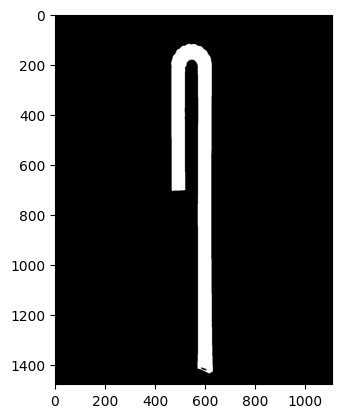

In [4]:
# rgb to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise (optional for Otsu's method)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Otsu's thresholding
ret, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')

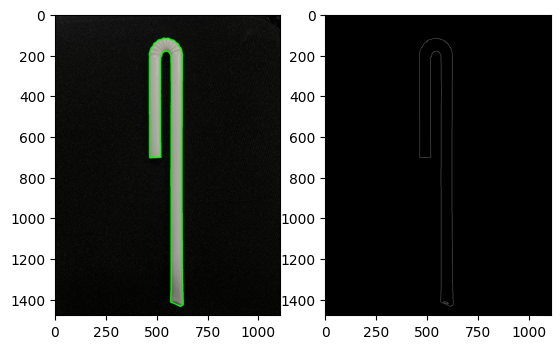

In [5]:
# edged detection
# Apply Canny Edge Detection to find the edges of the straw
edges = cv2.Canny(binary, threshold1=100, threshold2=150)
# find max contours
contours, hierarchy = cv2.findContours(edges,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
template_contour = max(contours, key=cv2.contourArea)

# Draw the contour on the image
roi_contour = cv2.drawContours(image.copy(), [template_contour], -1, (0, 255, 0), 5)

plt.subplot(121)
plt.imshow(roi_contour[:,:,::-1])
# plot contour
plt.subplot(122)
plt.imshow(edges, cmap='gray')

In [6]:
cv2.imwrite('../template/straw_template.jpg', binary)

True

# Inference

In [7]:

def to_binary(image, kernel=None, sigmax=0.5):
    if kernel is not None:
        # Apply Gaussian blur to reduce noise (optional for Otsu's method)
        blur = cv2.GaussianBlur(image, kernel, sigmax)
        # Apply Otsu's thresholding
        ret, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
    else:
        # Apply Otsu's thresholding
        ret, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        
    return binary

def get_contour(binary_image, threshold1=100, threshold2=150):
    # Apply Canny Edge Detection to find the edges of the straw
    edges = cv2.Canny(binary_image, threshold1, threshold2)
    # find max contours
    contours, hierarchy = cv2.findContours(edges,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    return contours, max(contours, key=cv2.contourArea)

def image_enhancement(image, kernel_size=3):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    # Apply histogram equalization to enhance contrast
    enhanced = cv2.equalizeHist(blur)
    return enhanced

# Function to calculate the Hausdorff distance
def hausdorff_distance(contour1, contour2):
    h1 = directed_hausdorff(contour1, contour2)[0]
    h2 = directed_hausdorff(contour2, contour1)[0]
    return max(h1, h2)

def align_contour_pca(contour):
    """
    Align a contour using PCA to remove rotation effects.
    Args:
        contour (np.ndarray): Input contour (Nx2 array of points).
    Returns:
        aligned_contour (np.ndarray): Rotated contour aligned to the principal axis.
    """
    # Center the points
    contour = contour.reshape(-1, 2)
    mean = np.mean(contour, axis=0)
    centered_contour = contour - mean

    # Perform PCA using Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(centered_contour.T)  # Vt contains eigenvectors as rows
    principal_axis = Vt[0]  # The principal component (largest eigenvector)

    # Align the principal axis with the x-axis
    angle = np.arctan2(principal_axis[1], principal_axis[0])
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
                                 [np.sin(-angle),  np.cos(-angle)]])
    aligned_contour = np.dot(centered_contour, rotation_matrix.T)

    return aligned_contour, mean

# Normalize contours by translating them to the origin (centroid alignment)
def align_contour(contour):
    M = cv2.moments(contour)
    cx, cy = int(M["m10"] / (M["m00"] + 1e-5)), int(M["m01"] / (M["m00"] + 1e-5))
    return contour - [cx, cy]

In [8]:
# import template
straw_template = cv2.imread('../template/straw_template.jpg', cv2.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(1107.5), np.float64(1476.5), np.float64(-0.5))

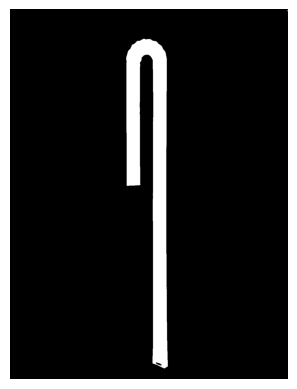

In [26]:
bin_img = to_binary(straw_template.copy(), kernel=(1, 1))
plt.imshow(bin_img, cmap='gray')
plt.axis('off')

In [10]:
contours, straw_contours = get_contour(bin_img)

aligned_model_contour, model_mean = align_contour_pca(np.squeeze(straw_contours))

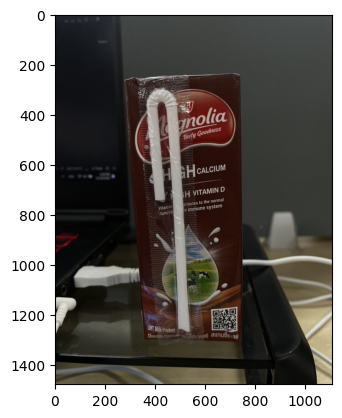

In [11]:
# impot test image
test_image = cv2.imread('../data/S__3129380.jpg')
plt.imshow(test_image[:,:,::-1])

In [12]:
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

In [13]:
# rgb to gray
h, w = test_image_gray.shape
x1, x2, y1, y2 = (w//3)-10, (w//3)*2, 200, h-100

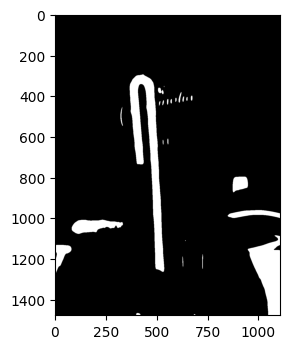

In [14]:
# bin_test_image = to_binary(test_image_gray[y1:y2, x1:x2], kernel=(5, 95), sigmax=0.0)
bin_test_image = to_binary(test_image_gray, kernel=(15, 65), sigmax=0.0)

# # clopped ROI
# h, w = bin_test_image.shape
# x1, x2, y1, y2 = (w//3)-10, (2*w//3), 250, h-200
# bin_test_image = bin_test_image[y1:y2, x1:x2]

plt.subplot(121)
plt.imshow(bin_test_image, cmap='gray')

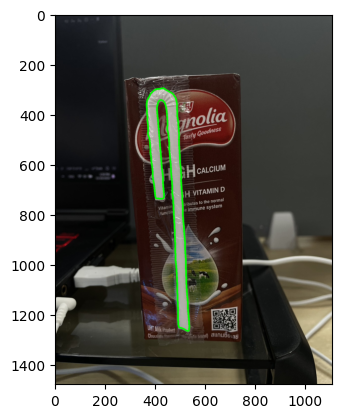

In [15]:
# find test image contours
contours, candidate_contour = get_contour(bin_test_image,  threshold1=50, threshold2=200)
# draw contours
candidate_contour_img = cv2.drawContours(test_image.copy(), candidate_contour, -1, (0, 255, 0), 5)
plt.imshow(candidate_contour_img[:,:,::-1])

In [16]:
# Use the largest contour
model_contour = template_contour
test_contour = candidate_contour

# Align both contours using PCA
aligned_model_contour, model_mean = align_contour_pca(np.squeeze(template_contour))
aligned_test_contour, test_mean = align_contour_pca(np.squeeze(candidate_contour))

In [17]:
# Hausdorff distance calculation
# h1 = directed_hausdorff(aligned_model_contour, aligned_test_contour)[0]
h2 = directed_hausdorff(aligned_test_contour, aligned_model_contour)[0]
# aligned_hausdorff_distance = max(h1, h2)
aligned_hausdorff_distance = h2

# percentage similarity

# Example maximum possible distance (e.g., diagonal of the image or bounding box)
model_bounding_box = cv2.boundingRect(template_contour)
test_bounding_box = cv2.boundingRect(candidate_contour)

# Calculate bounding box diagonals
model_diag = np.sqrt(model_bounding_box[2]**2 + model_bounding_box[3]**2)
test_diag = np.sqrt(test_bounding_box[2]**2 + test_bounding_box[3]**2)

# Define the maximum possible distance as the larger of the two diagonals
max_possible_distance = max(model_diag, test_diag)

# Convert Hausdorff Distance to Percentage Similarity
percentage_similarity = 100 * (1 - (aligned_hausdorff_distance / max_possible_distance))

# Define a threshold for similarity
threshold = 90  # Percentage
is_same_object = percentage_similarity >= threshold

# Display results
print(f"Hausdorff Distance: {aligned_hausdorff_distance:.2f}")
print(f"Percentage Similarity: {percentage_similarity:.2f}%")
print(f"[Threshold: {threshold}%] Are the objects the same? {'Yes' if is_same_object else 'No'}")


Hausdorff Distance: 27.39
Percentage Similarity: 97.94%
[Threshold: 90%] Are the objects the same? Yes


Percentage Similarity: 97.94%


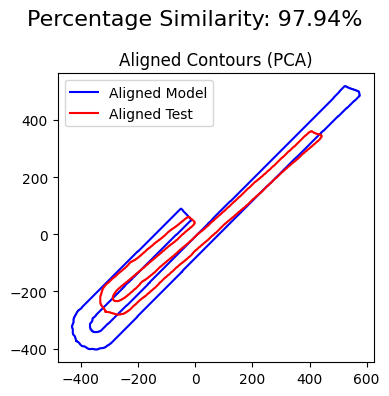

In [29]:
# Display results
print(f"Percentage Similarity: {percentage_similarity:.2f}%")

# Plot the original and aligned contours
plt.figure(figsize=(4, 4))

# Original contours
# plt.subplot(1, 2, 1)
# plt.title("Original Contours")
# plt.plot(model_contour[:, 0, 0], model_contour[:, 0, 1], label="Model", color="blue")
# plt.plot(test_contour[:, 0, 0], test_contour[:, 0, 1], label="Test", color="red")
# plt.legend()
# plt.axis('equal')

# Aligned contours
# plt.subplot(1, 2, 2)
plt.title("Aligned Contours (PCA)")
plt.plot(aligned_model_contour[:, 0], aligned_model_contour[:, 1], label="Aligned Model", color="blue")
plt.plot(aligned_test_contour[:, 0], aligned_test_contour[:, 1], label="Aligned Test", color="red")
plt.legend()
plt.axis('equal')

plt.suptitle(f"Percentage Similarity: {percentage_similarity:.2f}%", fontsize=16)
plt.tight_layout()
plt.show()

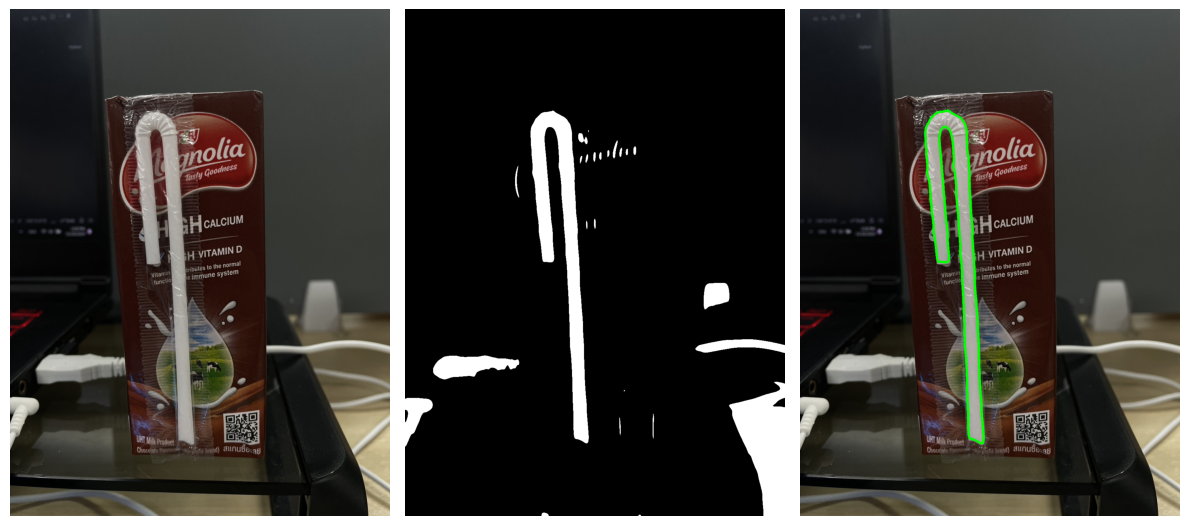

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(test_image[:,:,::-1], cmap='gray')
plt.axis('off')
# plt.title('Original Image')

plt.subplot(132)
plt.imshow(bin_test_image, cmap='gray')
plt.axis('off')
# plt.title('Binary Image')

plt.subplot(133)
plt.imshow(candidate_contour_img[:,:,::-1])
plt.axis('off')
# plt.title('Contour Image')

plt.tight_layout()
plt.show()